# Progetto Data Intensive 2021
https://www.kaggle.com/andrewmvd/fetal-health-classification

Anthony Cazzola- Matricola 0000882550

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import warnings
from sklearn.dummy import DummyClassifier
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore")
%matplotlib inline

#Introduzione 

Il Dataset è composto da 2126 misurazioni caratterizzate da 22 colonne.
Fra le feautures che caratterizzano ogni istanza c'è anche 'fetal_health' che rappresenta la classe di appartenza dello stato di salute del feto.
I dati del database infatti, sono raccolti attraverso esami CTG mentre lo stato di salute del feto è classificato da ostretici esperti, in 3 classi




*   Normale (1)
*   Sospetto (2)
*   Patologico (3)

Delle colonne che caratterizzano il database alcune rappresentano statistiche sui dati altre, piu utili all'obbiettivo, richiedono invece ulteriori descrizioni.

* **Baseline value** : la baseline value rappresenta il battito fetale(FHR)
l'FHR è calcolato monitorano il battito cardiaco in un intervallo di 10 minuti. Un FHR normale dovrebbe trovarsi tra i 110-160 bpm
* **Accelerations** : le accellerazioni sono aumenti del battito cardiaco di almeno 15 bpm sopra la baseline per almeno 15 secondi. Le accellerazioni del battito cardiaco sono normali, indicano che il feto ha un adeguato supporto d'ossigeno
* **Fetal movement** : Questa misura è calcolata attraverso il conteggio dei 'calci'(movimenti) del feto sentiti dalla madre.

* **Uterine_contractions** : Come suggerisce la parola, indica le contrazioni dell'utero.
Tale valore indica se la gravidanza e il travaglio stanno procedento nel migliore dei modi. Il numero di contrazioni non dovrebbe essere ne troppo alto ne troppo basso.
* **Decelerations** :  Le decellerazioni sono riferite sempre al battito cardiaco e indicano una diminuzione del battito cardiaco di almeno 15 bpm al di sotto della baseline per almeno 15 secondi.
Nel dataBase, sono divise in 3 tipi a seconda della loro gravità: light_decelerations, severe_deceleration, prolunged_deceleration
* **Short term variability (STV)** : Rappresenta la variazione del battito 'beat-to-beat' quindi l'oscillazione dell'FHR intorno alla baseline con un ampiezza  di 5-10 battiti 
* **Long term variability** : Rappresenta un oscillazione del battito cardiaco calcolata con una frequenza più bassa rispetto all STV e con un intervallo piu alto (da 10 a 25 bpm)

Il nostro obbiettivo quindi sarà quello, di classificare nel migliore dei modi lo stato di salute del feto conoscendo queste variabili.





#Esplorazione e pulizia dei dati


In [2]:
data= pd.read_csv('fetal_health.csv')

In [3]:

data.head(3)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

Per prima cosa assicuriamoci che non ci siano valori null all'interno del database.

In [5]:
data.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In più verifichiamo la presenza di dati ridondati per eliminarli

In [6]:
if(data.duplicated(keep='first').sum()>0):
  data.drop(data[data.duplicated(keep='first')].index, inplace=True)

data.duplicated(keep='first').sum()

0

Rinominiamo inoltre le colonne in modo da rendere il loro nome piu coinciso, senza perdita di generalità

In [7]:
data.rename(columns={'baseline value':'Baseline_FHR',
                     'abnormal_short_term_variability':'abnormal_STV', 'mean_value_of_short_term_variability':'mean_STV',
                     'percentage_of_time_with_abnormal_long_term_variability':'percentage_duration_LTV',
                     'mean_value_of_long_term_variability':'mean_LTV'}, inplace=True)

In più possimo anche togliere le colonne che rappresentano gli istogrammi, considerando che sono ricavati dai dati e non idispensabili per l'obbiettivo.

In [8]:
data=data.drop(columns=['histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency'])


In [9]:
data.head(5)

,Baseline_FHR,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_STV,mean_STV,percentage_duration_LTV,mean_LTV,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,1.0


Si puo ipotizzare, considerando la descrizione delle variabili riportate sopra che esista una qualche correlazione fra esse e la salute del feto.
Infatti, come descritto prima, misure come l'accellerazione la deccellerazione o le contrazioni uterine possono influenzare molto la salute del feto.
Vediamo quindi in che modo si relazionano le variabili per trarre qualche prima conclusione.

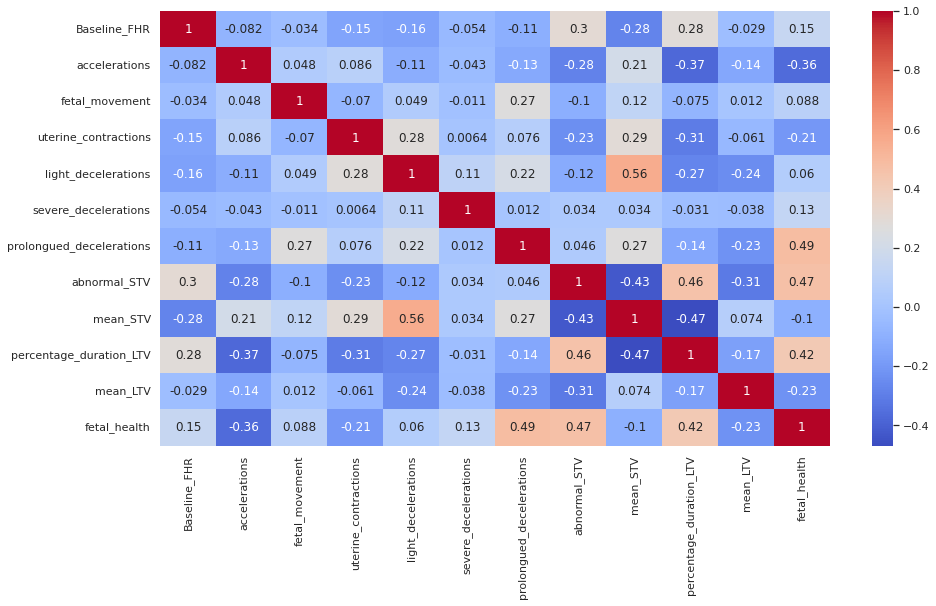

In [10]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm');

Dal grafico possiamo trarre alcune prime conclusioni:
* Esiste una forte relazione negativa fra le accellerazioni e la salute del feto.
Cio significa che le accelerazioni nel battito cardiaco hanno un ottimo significato.
* Al contempo esiste una forte correlazione fra le decellerazioni prolugati e, come prima, la salute del feto
* Inoltre possiamo notare che i bmp del feto non danno molte informazioni sul suo stato di salute.
Specifichiamo tutta via che il battito cardiaco dovrebbe trovarsi in un range fra 110-160 e analizzando il nostro database vediamo che i valori non si discostano di molto dall'intervallo ideale

In [11]:
print(f"I bpm al minimo sono : {data.Baseline_FHR.min()} BPM")
print(f"I bpm al massimo sono : {data.Baseline_FHR.max()} BPM")

I bpm al minimo sono : 106.0 BPM
I bpm al massimo sono : 160.0 BPM


Prima di iniziare l'analisi osserviamo che le classi target sono estremamente sbilanciate.
Questo è più che ragionevole: si presume che siano più i bambini nati in buono stato di salute rispetto a quelli che subiscono complicazioni

In [12]:
#per sicurezza cambio i valori target in 0, 1, 2
data['fetal_health'].replace({1:0,2:1,3:2}, inplace = True)
data.fetal_health.value_counts()

0.0    1646
1.0     292
2.0     175
Name: fetal_health, dtype: int64

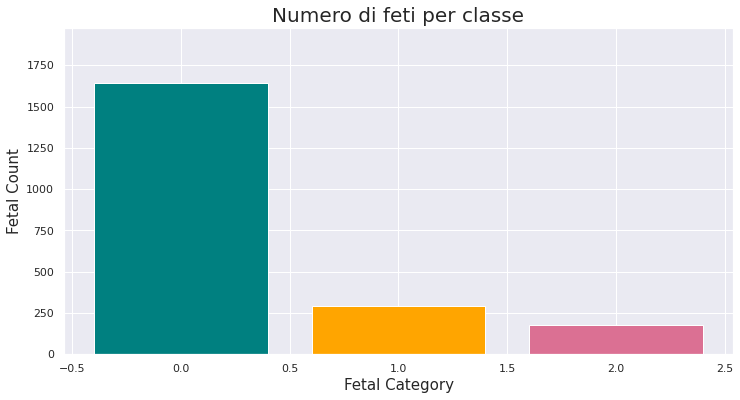

In [13]:
data_count= data.fetal_health.value_counts()
axis_x= data_count.index
axis_y=data_count.values
color=['teal', 'orange', 'palevioletred']
sns.set(font_scale=1)
plt.figure(figsize=(12,6))
plt.bar(x=axis_x, height=axis_y, color=color)
plt.title("Numero di feti per classe", fontsize=20)
plt.xlabel("Fetal Category", fontsize=15)
plt.ylabel("Fetal Count", fontsize=15)

    
plt.margins(y=0.2)

Durante l'analisi consideremo modelli bilanciati attraverso il parametro 'class_weigth' il quale permette di dare un peso differente alle classi.

#Previsone







Prima di tutto dividiamo il database in traing set e test set e ottieniamo uno 
score di riferimento da un modello casuale.
Il nostro modello sicuramente dovrà battere lo score di quello casuale.

In [14]:
from sklearn.model_selection import train_test_split
y = data['fetal_health']
x = data.drop(columns='fetal_health')
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=1/3,random_state=42)


In [15]:
random_model = Pipeline([
    ("scaler", StandardScaler()),
    ("dummy", DummyClassifier(strategy="most_frequent",  random_state=42))
])

random_model.fit(X_train, y_train)
random_model.score(X_test, y_test)


0.7886524822695036

#Perceptron

Il Perceptron è l'algoritmo di classificazione più semplice, volendo trovare una retta ( w*x + b=0 ) che separa una classe dalle altre, i parametri w e b sono inizializzati casualmente ed iterativamente vengo aggiornati per instanza mal classificata.

In [16]:
from sklearn.linear_model import Perceptron
percptron_model = Perceptron(random_state=42)
percptron_model.fit(X_train, y_train)
percptron_model.score(X_test, y_test)

0.7900709219858156

Abbiamo un accuratezza di circa il 76% ma se considerassimo il bilanciamento delle classi il risultato potrebbe cambiare

In [17]:

perceptron_model_balanced = Perceptron(random_state=42, class_weight='balanced')
perceptron_model_balanced.fit(X_train, y_train)
perceptron_model_balanced.score(X_test, y_test)

0.7219858156028369

vediamo che in effetti c'è poca differenza nello score non ostante il bilanciamento ma, per correttezza utilizzeremo il modello "balanced" durante l'analisi.
Osserviamo inoltre che il perceptron bilanciato non è riuscito a battere lo score del modello casuale.

#Regressione logistica









Il Perceptron è metodo molto semplice, utlizzare modelli piu complessi come la regressione logistica potrebbe migliorare il risultato.
Utilizzando la regressione logistica, conviene  normalizzare i coefficenti attraverso norma 1 (L1) o norma 2 (L2).
Per ottenere un miglior risultato quindi, utilizziamo una griglia contente i possibili iperparametri per il modello e attraverso la grid search ci assicuriamo di scegliere i migliori.

In [18]:

skf = StratifiedKFold(3, shuffle=True)
logistic_model = Pipeline([
    ("scaler", StandardScaler()),

    ("logreg", LogisticRegression(solver="saga", random_state=42 ,class_weight='balanced'))
])
grid_reg = {
    "logreg__penalty": ["l2", "l1"],
    "logreg__C": np.logspace(-5,3,9),
    "logreg__multi_class": ["ovr", "multinomial"]
}
gs_reg= GridSearchCV(logistic_model, grid_reg, cv=skf)
gs_reg.fit(X_train, y_train);
gs_reg.score(X_test, y_test)

0.851063829787234

Come ci aspettavamo lo score dato dalla regressione logistica è nettamente migliore rispetto quello del perceptron.
Ma lo score non è il miglior modo per misurare la bontà di un modello.
Al posto dello score è meglio usare misure statistiche come la confusion matrix e la f1 meausre

In [19]:
#funzione che stampa alcune misure in base ai modelli che gli vengono passati
def comparison(models): 
  model_accuracy= pd.DataFrame(columns=['Model', 'Accuracy'])

  for name, model in models.items():
    y_pred= model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    train_pred= model.predict(X_train)
    train_acc= accuracy_score(y_train, train_pred)
    print(name + ' scores')
    print(acc)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print('~' * 100)
    model_accuracy = model_accuracy.append({'Model': name, 'Accuracy': acc, 'Train_acc': train_acc}, ignore_index=True)

In [20]:

models= {'BalancedPerceptron': perceptron_model_balanced, 'LogisticReg': gs_reg, 'Dummy':random_model}
model_accuracy= pd.DataFrame(columns=['Model', 'Accuracy'])
comparison(models)

BalancedPerceptron scores
0.7219858156028369
              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85       556
         1.0       0.52      0.28      0.36        96
         2.0       0.25      0.83      0.38        53

    accuracy                           0.72       705
   macro avg       0.56      0.63      0.53       705
weighted avg       0.82      0.72      0.75       705

[[438  23  95]
 [ 30  27  39]
 [  7   2  44]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LogisticReg scores
0.851063829787234
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91       556
         1.0       0.54      0.88      0.67        96
         2.0       0.64      0.70      0.67        53

    accuracy                           0.85       705
   macro avg       0.72      0.81      0.75       705
weighted avg       0.89      0.85      0.86       705

[[479  59

La confusion matrix è una matrice la cui diagonale rappresenta i valori predetti correttamente.
Come possiamo inferire dalla matrice del perceptron questo modello sbaglia con una frequenza maggiore rispetto alla regressione logistica ma fa meglio rispetto al modello casuale, come ci si aspetta.
Anche la F1 measure, misura utilizzata per confrontare due o più modelli, basata su precision e recall ci conferma quanto inferito dalla confusion matrix

#SVM

Oltre alla regressione logistica esistono altri metodi più complessi che possiamo considerare per la nostra analisi, fra questi SVM (Support vector machine)
Le support vector machine sfruttano le istanze vicine al decison bundary per trovare gli iperpiani di separazione migliori quindi che generino meno overfitting e quindi definiscano il maggior margine fra le classi.
Le SVM nascono per affrontare problemi binari, con classi separabili linearmente ma sfruttando le funzioni kernel si possono applicare anche a problemi non linearmente separabili

In [21]:

model_SVM = Pipeline([
    ("scaler", StandardScaler()),

    ("svc", SVC(class_weight='balanced'))
])
grid3 = {
    'svc__C' : np.logspace(-3,5,9),
    'svc__kernel' : [ 'poly', 'rbf']
}
gs_SVM = GridSearchCV(model_SVM, grid3, cv=skf)
gs_SVM.fit(X_train, y_train);


In [22]:
models= {'SVM': gs_SVM, 'LogisticReg': gs_reg}
comparison(models)

SVM scores
0.9177304964539007
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       556
         1.0       0.69      0.80      0.74        96
         2.0       0.90      0.89      0.90        53

    accuracy                           0.92       705
   macro avg       0.85      0.88      0.86       705
weighted avg       0.92      0.92      0.92       705

[[523  31   2]
 [ 16  77   3]
 [  3   3  47]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LogisticReg scores
0.851063829787234
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91       556
         1.0       0.54      0.88      0.67        96
         2.0       0.64      0.70      0.67        53

    accuracy                           0.85       705
   macro avg       0.72      0.81      0.75       705
weighted avg       0.89      0.85      0.86       705

[[479  59  18]
 [  9  84

Applicando una gridSearch per definire:  

*   C: di quanto spostare i parametri missclassified
*   kernel:  il tipo di fuzione kerneld usare

possiamo aumentare lo score fino a circa il 90% migliorando anche la F1 measure 

#Decison tree


Lo svantaggio di SVM con gridSearch è quello di impiegare più tempo per ottenere il risultato.
Una soluzione più efficiente sta negli algoritmi che sfruttano gli alberi per definire la classe di appartenza.
Questi algoritmi risultano essere piu veloci di SVM e producono in egual modo ottimi risultati



In [23]:

model_tree = Pipeline([
    ("scaler", StandardScaler()),
    ('tree', DecisionTreeClassifier(random_state=42))
])
grid = {
         "tree__max_depth" : [5, 10, 15, 20],
         "tree__min_samples_leaf": [1, 5, 10, 15],
         "tree__min_samples_split": [2, 5, 10, 20],
          "tree__class_weight": ["balanced"]
}
gs_tree = GridSearchCV(model_tree, grid, cv=skf)
gs_tree.fit(X_train, y_train)
gs_tree.score(X_test, y_test)

0.9234042553191489

In [24]:
models= {'LogisticReg': gs_reg, 'SVM': gs_SVM,  'DecisionTree': gs_tree}
comparison(models)

LogisticReg scores
0.851063829787234
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91       556
         1.0       0.54      0.88      0.67        96
         2.0       0.64      0.70      0.67        53

    accuracy                           0.85       705
   macro avg       0.72      0.81      0.75       705
weighted avg       0.89      0.85      0.86       705

[[479  59  18]
 [  9  84   3]
 [  3  13  37]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SVM scores
0.9177304964539007
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       556
         1.0       0.69      0.80      0.74        96
         2.0       0.90      0.89      0.90        53

    accuracy                           0.92       705
   macro avg       0.85      0.88      0.86       705
weighted avg       0.92      0.92      0.92       705

[[523  31   2]
 [ 16  77

Possiamo verificare a quali attributi il decision tree dia più importanza per ottenere tali risultati

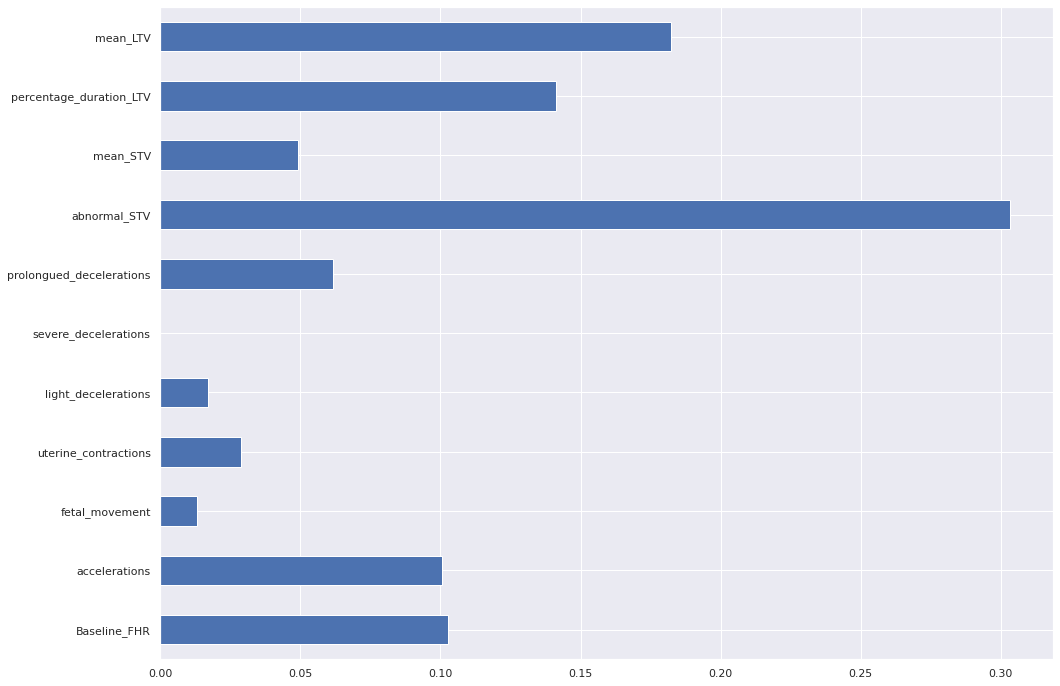

In [25]:
labels= list(data.columns)
labels.remove('fetal_health')
tree_feauture=pd.Series(gs_tree.best_estimator_.named_steps["tree"].feature_importances_, index=labels)
tree_feauture.plot(kind='barh', figsize=(16,12))

stampando i tempi

In [26]:
%%time
gs_tree = GridSearchCV(model_tree, grid, cv=skf)
gs_tree.fit(X_train, y_train)
gs_tree.score(X_test, y_test)

CPU times: user 1.7 s, sys: 12.9 ms, total: 1.71 s
Wall time: 1.71 s


In [27]:
%%time
gs_reg= GridSearchCV(logistic_model, grid_reg, cv=skf)
gs_reg.fit(X_train, y_train);
gs_reg.score(X_test, y_test)

CPU times: user 4 s, sys: 5.63 ms, total: 4 s
Wall time: 4.01 s


In [28]:
%%time
gs_SVM = GridSearchCV(model_SVM, grid3, cv=skf)
gs_SVM.fit(X_train, y_train);
gs_SVM.score(X_test, y_test)

CPU times: user 6.19 s, sys: 14.5 ms, total: 6.2 s
Wall time: 6.18 s


#Valutazione statistica

In [29]:
def eval_difference_two_model(acc1, acc2, N1, N2, alpha, confidence_level=True):

    print(f"\n*** Valutazione statistica differenza tra modello 1 e modello 2 ***")
    print(f"(acc: {acc1}, N: {N1}) (acc: {acc2}, N: {N2})\n")
    Z = st.norm.ppf(1-alpha/2)
    e1 = 1 - acc1; e2 = 1 - acc2
    d= abs(e2-e1)
    var_d = (e1*(1-e1))/N1 + (e2*(1-e2))/N2
    d_min = d - Z * var_d**0.5
    d_max = d + Z * var_d**0.5
    
    if confidence_level:
        print(f"\n*** Valutazione soglia confidenza che rende significativa la differenza tra i due modelli ***")
        print(f"a: {np.round(st.norm.sf(d/var_d**0.5) * 2, 2)}\n")
    
    return d_min, d_max


In [30]:
y_pred_tree=gs_tree.predict(X_test)
tree_acc=accuracy_score(y_test, y_pred_tree)
y_pred_svm=gs_SVM.predict(X_test)
svm_acc=accuracy_score(y_test, y_pred_svm)


In [31]:
eval_difference_two_model(acc1=tree_acc, acc2=svm_acc, N1=X_test.shape[0], N2=X_test.shape[0], alpha=0.05)


*** Valutazione statistica differenza tra modello 1 e modello 2 ***
(acc: 0.9234042553191489, N: 705) (acc: 0.9177304964539007, N: 705)


*** Valutazione soglia confidenza che rende significativa la differenza tra i due modelli ***
a: 0.69



(-0.022553705957244867, 0.03390122368774134)

Con confidenza di 0.95 la differenza di performance fra i due modelli è frutto del caso.
Per ottener una differenza significativa è necessario che la confidenza sia < 76
possiamo considerare la differenza di performance fra i due modelli frutto del caso.

Considerando il modello casuale invece, ci accorgiamo, come è ragionevole che sia, che la differenza fra i due modelli è sempre significativa e mai frutto del caso.

In [32]:
y_pred_rand= random_model.predict(X_test)
random_acc= accuracy_score(y_test, y_pred_rand)

In [33]:
eval_difference_two_model(acc1=svm_acc, acc2=random_acc, N1=X_test.shape[0], N2=X_test.shape[0], alpha=0.05)


*** Valutazione statistica differenza tra modello 1 e modello 2 ***
(acc: 0.9177304964539007, N: 705) (acc: 0.7886524822695036, N: 705)


*** Valutazione soglia confidenza che rende significativa la differenza tra i due modelli ***
a: 0.0



(0.09275151506309748, 0.16540451330569678)

#Bilanciamento
Esiste un altro modo per bilanciare la classi.
Attraverso SMOTE infatti si creano( rispettando la distribuzione di quelle gia presenti) delle istantze fittizie appartenenti alla classe meno rappresentata per bilanciare il database.

In [34]:
from imblearn.over_sampling import SMOTE

balancer = SMOTE(random_state=42)


In [35]:
X_train_smote = pd.DataFrame(balancer.fit_resample(X_train, y_train)[0])
y_train_smote = pd.DataFrame(balancer.fit_resample(X_train, y_train)[1])


In [36]:
tree_balaced_model = Pipeline([
    ("scaler", StandardScaler()),
   ('tree', DecisionTreeClassifier(max_depth=15, random_state=42, min_samples_split=2, min_samples_leaf=1))
])
    


tree_balaced_model.fit(X_train_smote, y_train_smote)
tree_balaced_model.score(X_test, y_test)

0.9134751773049645

In [37]:
models= {'TREE': gs_tree, 'BALANCED_TREE': tree_balaced_model}
comparison(models)

TREE scores
0.9234042553191489
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       556
         1.0       0.81      0.71      0.76        96
         2.0       0.85      0.87      0.86        53

    accuracy                           0.92       705
   macro avg       0.87      0.85      0.86       705
weighted avg       0.92      0.92      0.92       705

[[537  14   5]
 [ 25  68   3]
 [  5   2  46]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
BALANCED_TREE scores
0.9134751773049645
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       556
         1.0       0.75      0.71      0.73        96
         2.0       0.81      0.91      0.86        53

    accuracy                           0.91       705
   macro avg       0.84      0.85      0.84       705
weighted avg       0.91      0.91      0.91       705

[[528  21   7]
 [ 24

Confrontando i modelli bilanciati attraverso il parametro 'class_weigth' e attraverso smote osserviamo che i risultati non discostano eccessivamentefra loro. 

#Conclusioni

Esistono altri modelli più complessi che possono portare la precisione fino al 95%.
In prima analisi, tutta via, i risultati ottenuti dai modelli sopra descritti sembrano più che ottimi.
Il modello migliore per rapidità  è quello che sfrutta gli alberi di regressione in più come osservato prima non risulatano esserci differenze statisticamente significative con l'SVM.
Quest'ultimo modello (SVM) ha ottime performance a fronte di un maggiore tempo di attesa, considerando i parametri inseriti nella grid search.

La regressione logistica batte il modello casuale ma non è preferibile ai modelli sopra descritti.